# Visualizing the data

In this notebook we'll go over how to curate and visualize the data in a chart using `d3.js`

First, we'll define a helper function for loading our CSV data.

In [39]:
import dataForge from "data-forge";
import "data-forge-fs";

const loadCSV = (filePath: string) => {
  const result = dataForge
    .readFileSync(filePath) // Read input file.
    .parseCSV()
    .asJSON();
  return (result as any).dataframe.content;
};

const csvData = loadCSV("/Users/bracesproul/Downloads/titanic.csv");
console.log(csvData.values.rows.length);
console.log(csvData.values.columnNames);

887
[
  "Survived",
  "Pclass",
  "Name",
  "Sex",
  "Age",
  "Siblings/Spouses Aboard",
  "Parents/Children Aboard",
  "Fare"
]


Then, we can pass it to a DataFrame from `data-forge`.

In [40]:
import { DataFrame } from 'data-forge';

const df = new DataFrame(csvData);
console.log(df.content.values.rows.length);

887


One issue with this data format is the column names are an array of strings, and the rows are stored in a 2d array with their indices corresponding to the indices of the column names. This makes it difficult to access the data in a way that is easy to understand. We'll convert the data to an array of objects where the keys are the column names and the values are the row values.

In [41]:
const data: Array<Record<string, string>> = [];
const rows: Array<string[]> = df.content.values.rows;
const columnNames = df.getColumnNames();

// Calculate total survived and total count by class
rows.forEach((row) => {
  const rowData = columnNames.reduce((acc, col, idx) => {
    acc[col] = row[idx];
    return acc;
  }, {});
  data.push(rowData);
});
console.log(data[0]);

{
  Survived: "0",
  Pclass: "3",
  Name: "Mr. Owen Harris Braund",
  Sex: "male",
  Age: "22",
  "Siblings/Spouses Aboard": "1",
  "Parents/Children Aboard": "0",
  Fare: "7.25"
}


Next, we'll use `d3.js` to construct a function for generating and displaying charts.

In [42]:
import * as d3 from "d3";
import { createCanvas } from "skia_canvas";

type SurvivalRate = {
  label: string;
  value: number;
};

const canvas = async (data: Array<SurvivalRate>) => {
  // const data = input.data;
  const width = 500;
  const height = 500;
  const margin = { top: 20, right: 30, bottom: 30, left: 40 };

  const canvas = createCanvas(width, height);
  const ctx = canvas.getContext("2d");

  const x = d3
    .scaleBand()
    .domain(data.map((d) => d.label))
    .range([margin.left, width - margin.right])
    .padding(0.1);

  const y = d3
    .scaleLinear()
    .domain([0, d3.max(data, (d) => d.value)])
    .nice()
    .range([height - margin.bottom, margin.top]);

  const colorPalette = [
    "#e6194B",
    "#3cb44b",
    "#ffe119",
    "#4363d8",
    "#f58231",
    "#911eb4",
    "#42d4f4",
    "#f032e6",
    "#bfef45",
    "#fabebe",
  ];

  data.forEach((d, idx) => {
    ctx.fillStyle = colorPalette[idx % colorPalette.length];
    ctx.fillRect(
      x(d.label),
       y(d.value),
      x.bandwidth(),
      height - margin.bottom - y(d.value),
    );
  });

  ctx.beginPath();
  ctx.strokeStyle = "black";
  ctx.moveTo(margin.left, height - margin.bottom);
  ctx.lineTo(width - margin.right, height - margin.bottom);
  ctx.stroke();

  ctx.textAlign = "center";
  ctx.textBaseline = "top";
  x.domain().forEach((d) => {
    const xCoord = x(d) + x.bandwidth() / 2;
    ctx.fillText(d, xCoord, height - margin.bottom + 6);
  });

  ctx.beginPath();
  ctx.moveTo(margin.left, height - margin.top);
  ctx.lineTo(margin.left, height - margin.bottom);
  ctx.stroke();

  ctx.textAlign = "right";
  ctx.textBaseline = "middle";
  const ticks = y.ticks();
  ticks.forEach((d) => {
    const yCoord = y(d); // height - margin.bottom - y(d);
    ctx.moveTo(margin.left, yCoord);
    ctx.lineTo(margin.left - 6, yCoord);
    ctx.stroke();
    ctx.fillText(d, margin.left - 8, yCoord);
  });

  await Deno.jupyter.display(canvas);
};

Now, using our dataframe we can calculate the survival rate for each class.

In [43]:
const survivalSumByClass: { [key: string]: number } = {};
const totalCountByClass: { [key: string]: number } = {};

// Calculate total survived and total count by class
data.forEach((row) => {
  const pclass = row.Pclass;
  if (!(pclass in survivalSumByClass)) {
    survivalSumByClass[pclass] = 0;
    totalCountByClass[pclass] = 0;
  }
  survivalSumByClass[pclass] += row.Survived === "1" ? 1 : 0;
  totalCountByClass[pclass] += 1;
});

// Map to desired structure
const survivalRates: SurvivalRate[] = Object.keys(survivalSumByClass).map((key) => {
  const pclass = parseInt(key);
  const survivalRate = survivalSumByClass[pclass] / totalCountByClass[pclass];
  return {
    label: `Class ${pclass}`,
    value: survivalRate,
  };
});

console.log(survivalRates);

[
  { label: "Class 1", value: 0.6296296296296297 },
  { label: "Class 2", value: 0.47282608695652173 },
  { label: "Class 3", value: 0.24435318275154005 }
]


Now that we have our data on survival rates by class, we can pass it to our canvas to be displayed.

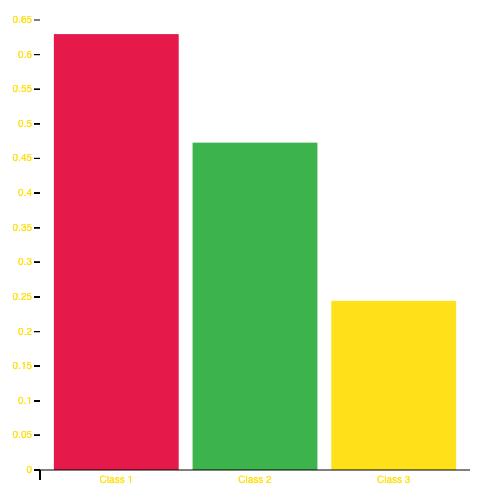

In [44]:
await canvas(survivalRates);